# EDA: Intentional Homicide Victims (Group 10)

Notebook generated automatically. Run cells to reproduce the analysis.

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

out_dir = Path('..') / 'outputs'
clean = out_dir / 'homicide_clean.csv'
df = pd.read_csv(clean)
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['VALUE'] = pd.to_numeric(df['VALUE'], errors='coerce')
print('Loaded', len(df), 'rows')

df.head()


Loaded 118397 rows


,Iso3_code,Region,Subregion,Country,Source,Dimension,Category,Sex,Age,Year,Unit of measurement,VALUE
0,ARM,Asia,Western Asia,Armenia,CTS,by citizenship,National citizens,Male,Total,2013,Counts,35.0
1,CHE,Europe,Western Europe,Switzerland,CTS,by citizenship,National citizens,Male,Total,2013,Counts,28.0
2,COL,Americas,Latin America and the Caribbean,Colombia,CTS,by citizenship,National citizens,Male,Total,2013,Counts,15053.0
3,CZE,Europe,Eastern Europe,Czechia,CTS,by citizenship,National citizens,Male,Total,2013,Counts,69.0
4,DEU,Europe,Western Europe,Germany,CTS,by citizenship,National citizens,Male,Total,2013,Counts,455.0


## Top 10 countries in most recent year

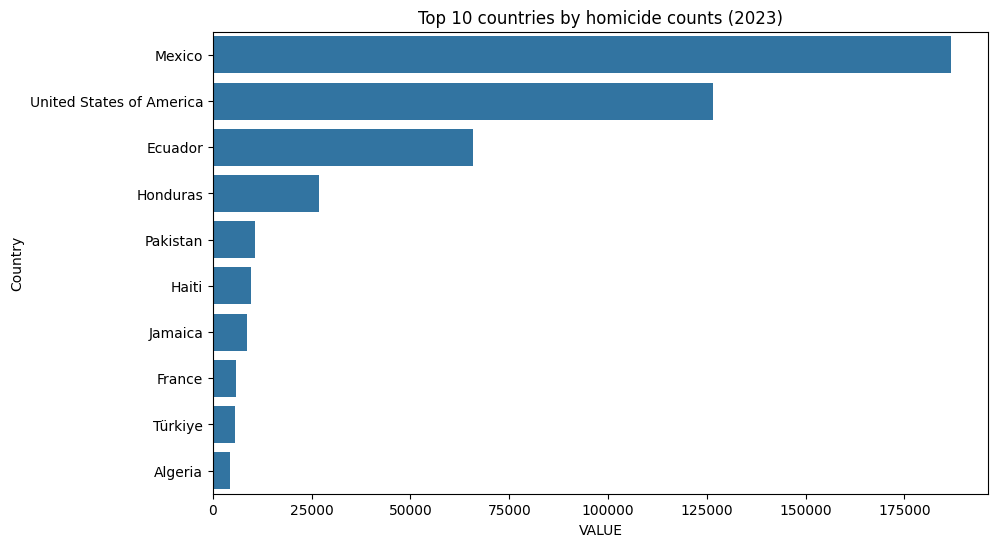

In [2]:
latest = int(df['Year'].max())
recent = df[df['Year']==latest]
top10 = recent.groupby('Country', as_index=False)['VALUE'].sum().sort_values('VALUE', ascending=False).head(10)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
import seaborn as sns
sns.barplot(data=top10, x='VALUE', y='Country')
plt.title(f'Top 10 countries by homicide counts ({latest})')
plt.show()


## Regional totals

In [3]:
region_tot = recent.groupby('Region', as_index=False)['VALUE'].sum().sort_values('VALUE', ascending=False)
region_tot.head()


,Region,VALUE
1,Americas,428394.906464
2,Asia,18815.143276
3,Europe,17065.329192
0,Africa,8424.711092
4,Oceania,923.684028


## Global trend

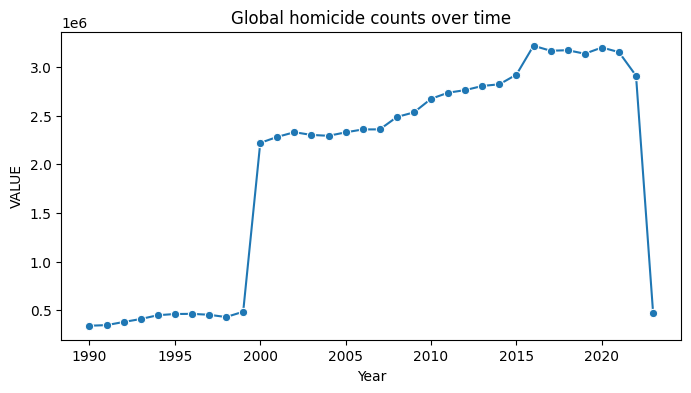

In [4]:
world_trend = df.groupby('Year', as_index=False)['VALUE'].sum().sort_values('Year')
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
sns.lineplot(data=world_trend, x='Year', y='VALUE', marker='o')
plt.title('Global homicide counts over time')
plt.show()


## Notes and next steps
- To compute rates per 100,000, we will fetch population data from the World Bank and merge on ISO3 and Year.
- The cells below fetch population (cached), compute rates, and produce rate-based top-10 results.

## Compute rates per 100,000 (World Bank population)
The next cell downloads population totals from the World Bank API for the country ISO3 codes present in the dataset and caches the results to `../outputs/worldbank_population.csv`. If you prefer not to fetch data, skip running the cell and provide a population file with columns `Iso3_code,Year,population`.

In [5]:
# Fetch population data from World Bank and cache locally
import requests, time
from pathlib import Path
out_dir = Path('..') / 'outputs'
out_dir.mkdir(parents=True, exist_ok=True)
pop_path = out_dir / 'worldbank_population.csv'
# If cached file exists, load it; otherwise fetch from the World Bank API
if pop_path.exists():
    pop_df = pd.read_csv(pop_path)
    print('Loaded cached population data:', pop_path)
else:
    isos = df['Iso3_code'].dropna().unique().tolist()
    year_min = int(df['Year'].min())
    year_max = int(df['Year'].max())
    print(f'Fetching population for {len(isos)} countries for years {year_min}-{year_max} (this may take a minute)')
    records = []
    for iso in isos:
        try:
            url = f'http://api.worldbank.org/v2/country/{iso}/indicator/SP.POP.TOTL?date={year_min}:{year_max}&format=json&per_page=1000'
            r = requests.get(url, timeout=15)
            j = r.json()
            if isinstance(j, list) and len(j) > 1:
                for item in j[1]:
                    y = item.get('date')
                    v = item.get('value')
                    if v is not None:
                        records.append({'Iso3_code': iso, 'Year': int(y), 'population': int(v)})
        except Exception as e:
            print('Failed to fetch', iso, e)
        time.sleep(0.12)
    pop_df = pd.DataFrame(records)
    pop_df.to_csv(pop_path, index=False)
    print('Wrote population cache to', pop_path)

Fetching population for 214 countries for years 1990-2023 (this may take a minute)


Failed to fetch AIA 'NoneType' object is not iterable


Failed to fetch CYM Expecting value: line 1 column 1 (char 0)


Failed to fetch SAU Expecting value: line 1 column 1 (char 0)


Failed to fetch NCL Expecting value: line 1 column 1 (char 0)


Failed to fetch MYT 'NoneType' object is not iterable


Wrote population cache to ..\outputs\worldbank_population.csv


### Prepare total (aggregate) homicide counts and merge with population
We will prefer observations labeled as 'Total' for Category, Sex and Age. If those exact labels are not present, the code falls back to using Category 'Total' only.

In [6]:
# Prepare totals and merge with population
tot = df.copy()
# Normalize text fields to allow case-insensitive matching
for c in ['Category','Sex','Age']:
    if c in tot.columns:
        tot[c] = tot[c].astype(str).str.strip()
# Build masks for 'Total' where available
mask_cat = tot['Category'].str.lower().str.contains('total', na=False) if 'Category' in tot.columns else pd.Series(True, index=tot.index)
mask_sex = tot['Sex'].str.lower().str.contains('total', na=False) if 'Sex' in tot.columns else pd.Series(True, index=tot.index)
mask_age = tot['Age'].str.lower().str.contains('total', na=False) if 'Age' in tot.columns else pd.Series(True, index=tot.index)
mask = mask_cat & mask_sex & mask_age
if mask.sum() == 0:
    # fallback: use Category 'Total' only
    mask = mask_cat
tot = tot[mask].copy()
# Aggregate counts by Iso3_code/Country/Year
agg = tot.groupby(['Iso3_code','Country','Year'], as_index=False)['VALUE'].sum()
# Load population (pop_df should already be defined from previous cell)
try:
    pop_df
except NameError:
    raise RuntimeError('Population data not loaded. Run the population fetch cell or provide a population CSV at ../outputs/worldbank_population.csv')
# Merge and compute rate per 100k
merged = pd.merge(agg, pop_df, on=['Iso3_code','Year'], how='left')
merged['population'] = pd.to_numeric(merged['population'], errors='coerce')
merged['rate_per_100k'] = merged['VALUE'] / merged['population'] * 100000
# Save results
merged.to_csv(out_dir / 'homicide_rates.csv', index=False)
print('Wrote homicide_rates.csv with', len(merged), 'rows')
# Show missing population matches
missing_pop = merged['population'].isna().sum()
print('Rows with missing population:', missing_pop)
merged.head()

Wrote homicide_rates.csv with 4537 rows
Rows with missing population: 409


,Iso3_code,Country,Year,VALUE,population,rate_per_100k
0,ABW,Aruba,1990,0.000000,62753.0,0.000000
1,ABW,Aruba,1995,13.903264,79805.0,17.421545
2,ABW,Aruba,1999,4.312901,89659.0,4.810338
3,ABW,Aruba,2001,8.429434,91439.0,9.218641
4,ABW,Aruba,2002,10.471747,92074.0,11.373185


## Top 10 countries by homicide rate (per 100,000) — most recent year

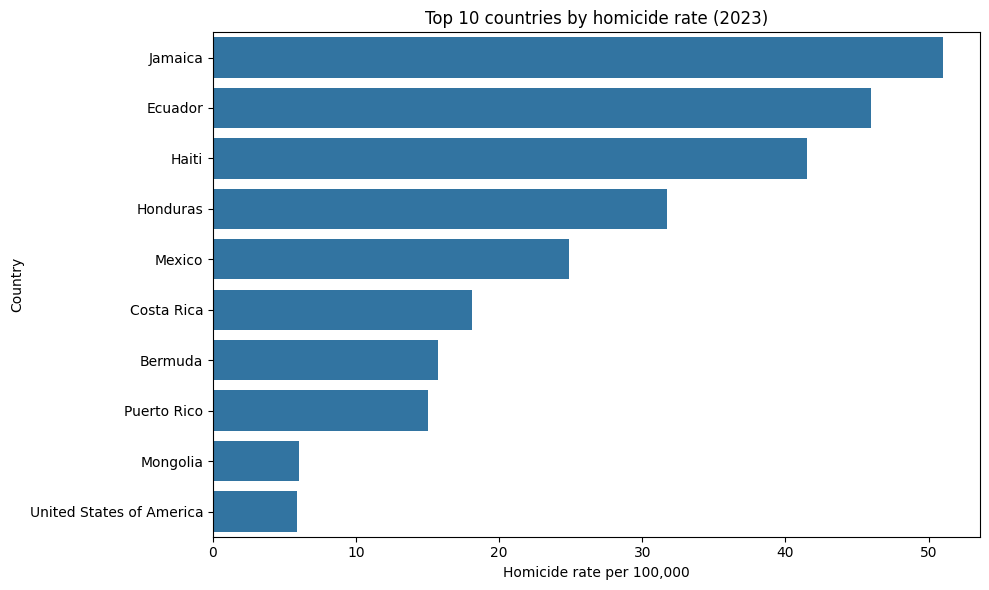

,Country,rate_per_100k
2191,Jamaica,51.04
1301,Ecuador,45.98
1918,Haiti,41.51
1870,Honduras,31.74
2795,Mexico,24.88
1001,Costa Rica,18.09
667,Bermuda,15.74
3427,Puerto Rico,14.99
2919,Mongolia,6.00
4288,United States of America,5.88


In [7]:
rates = merged.copy()
rates['Year'] = pd.to_numeric(rates['Year'], errors='coerce')
latest = int(rates['Year'].max())
rt = rates[rates['Year']==latest].dropna(subset=['rate_per_100k'])
top10_rate = rt.sort_values('rate_per_100k', ascending=False).head(10)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.barplot(data=top10_rate, x='rate_per_100k', y='Country')
plt.xlabel('Homicide rate per 100,000')
plt.title(f'Top 10 countries by homicide rate ({latest})')
plt.tight_layout()
plt.show()
top10_rate[['Country','rate_per_100k']].round(2)

## Notes
- Some countries/years may be missing population data from the World Bank; you can provide a local population CSV if needed.
- Rates are computed from the aggregated counts chosen by the 'Total' heuristics above; review the `tot` selection if you want e.g. sex-specific rates.